In [1]:
%matplotlib inline
import numpy as np
from pvextractor import Path, extract_pv_slice
from astropy import units as u
from astropy.coordinates import SkyCoord
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import regions
from NOEMAsetup import *

## SO_56_45

First, we set up the parameters we need

In [42]:
savepv = 0
saveplot = 0

vmin = 0.
vmax = 0.6
stretch = 'linear'
velinit = 0
velend = 14
widthpv = 0.5 # px here we can experiment with different widths

radiusplot = 8/3600

folder = '../'
cubename = folder + SO_56_45

# plotname = folder+'SO_56_45/CDconfig/pvdiagrams/pvex_SO_56_45_pvline_' + str(widthpv)+'px'
plotname = folder+'SO_56_45/CDconfig/pvdiagrams/pvex_SO_56_45_pvline_05'+'px'
regionfile = folder + 'SO_56_45/CDconfig/pvline.reg'

Then, we obtain the PV cut in the region defined

In [43]:
cube = SpectralCube.read(cubename+'.fits').with_spectral_unit(u.km/u.s).spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
header = cube.header
ra = header['RA']
dec = header['DEC']

moment0 = cube.moment(order=0).hdu
wcsmom0 = WCS(moment0.header)

reg_sky = regions.read_ds9(regionfile)[0]
pvline = reg_sky.to_pixel(wcsmom0)

x0, y0 = reg_sky.start.ra.value, reg_sky.start.dec.value
x1, y1 = reg_sky.end.ra.value, reg_sky.end.dec.value
g = SkyCoord([x0, x1] *u.deg, [y0, y1]*u.deg) #from xx to xx
path = Path(g, width=widthpv)

slice1 = extract_pv_slice(cube, path)
if savepv:
    slice1.writeto(plotname+'.fits')


We plot a two-panel plot to see the results

<ipython-input-44-1c170153538a>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(offset, velrange, slice1.data, cmap='inferno', norm=norm)


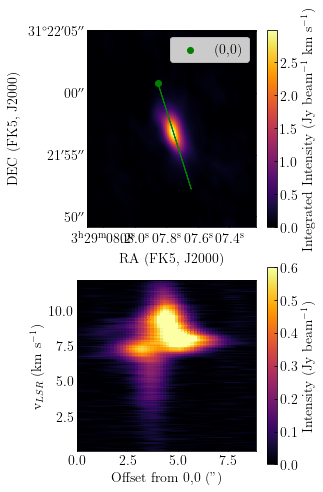

In [44]:
norm = simple_norm(slice1.data, stretch, min_cut=vmin, max_cut=vmax)

wcs = WCS(slice1.header)
len0 = slice1.header['NAXIS1']
offset0 = slice1.header['CRVAL1']
i0 = slice1.header['CRPIX1']
delta0 = slice1.header['CDELT1']
len1 =slice1.header['NAXIS2']
vel1 = slice1.header['CRVAL2']
i1 = slice1.header['CRPIX2']
delta1 = slice1.header['CDELT2']
offset = np.array([(offset0 + delta0*(i-i0+1))for i in range(len0)])*3600
velrange = np.array([(vel1 + delta1*(i-i1+1)) for i in range(len1)])/1.e3
zoomlims = wcsmom0.all_world2pix([ra-radiusplot, ra+radiusplot],
                             [dec-radiusplot, dec+radiusplot], 0)
artist = pvline.as_artist()
fig = plt.figure(figsize=(4,8))

ax = fig.add_subplot(211, projection=wcsmom0)
im = ax.imshow(moment0.data, cmap='inferno', vmin=0)
ax.scatter(pvline.start.x, pvline.start.y, color='g', label='(0,0)')
fig.colorbar(im, ax=ax, label=r'Integrated Intensity (Jy beam$^{-1}$ km s$^{-1}$)')
ax.set_xlim(zoomlims[0][1], zoomlims[0][0])
ax.set_ylim(zoomlims[1][0], zoomlims[1][1])
ax.add_artist(artist)
ax.set_xlabel('RA (FK5, J2000)')
ax.set_ylabel('DEC (FK5, J2000)')
ax.legend()

ax = fig.add_subplot(212)
im = ax.pcolor(offset, velrange, slice1.data, cmap='inferno', norm=norm)
fig.colorbar(im,ax=ax, label=r'Intensity (Jy beam$^{-1}$)')
ax.set_aspect(aspect=0.7)
ax.set_xlabel('Offset from 0,0 (")')
ax.set_ylabel(r'v$_{LSR}$ (km s$^{-1}$)')
if saveplot:
    fig.savefig(plotname, bbox_inches='tight')
